In [1]:
# data setup imports
import pandas as pd
from datetime import date
import time
import calendar
import matplotlib.pyplot as plt
import numpy as np

# sklearn imports
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

file_name = "../Traffic_Violations.csv"
df = pd.read_csv(file_name)

In [2]:
# Data cleaning/setup - general filtering of data

# Let's drop the columns we deem irrelevant!
filtered_cols_df = df.drop(['Driver City', 'Driver State','DL State', 'Arrest Type','Agency', 'SubAgency', 'Location', 'Latitude', 'Longitude', 'HAZMAT', 'Work Zone', 'Geolocation', 'Charge', 'Article'], axis=1)

# Change all Date Of Stop dates to weekdays. Hopefully I can find patterns regarding when violations occur during the week
filtered_cols_df['Date Of Stop'] = filtered_cols_df['Date Of Stop'].map(lambda a: time.strftime("%A", time.strptime(a, "%m/%d/%Y")))

# Time Of Stop is now modified with just the hour of the day in military time
filtered_cols_df['Time Of Stop'] = filtered_cols_df['Time Of Stop'].map(lambda a: time.strftime("%H", time.strptime(a, "%H:%M:%S")))


In [3]:
# Data cleaning/setup for drunk driving incidents

# Take out only the drunk driving related incidents
drunk_driving_df = filtered_cols_df[(filtered_cols_df['Description'] == 'DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF ALCOHOL')]
drunk_driving_df_2 = filtered_cols_df[(filtered_cols_df['Description'] == 'DRIVING WHILE IMPAIRED BY ALCOHOL')]
drunk_driving_df.append(drunk_driving_df_2)
drunk_driving_df = drunk_driving_df.drop(['Description', 'Model'], axis=1)

print("Shape of dataframe: ", drunk_driving_df.shape)

drunk_driving_df.head(3)
# drunk_driving_df['VehicleType'].value_counts()


Shape of dataframe:  (17974, 19)


,Date Of Stop,Time Of Stop,Accident,Belts,Personal Injury,Property Damage,Fatal,Commercial License,Commercial Vehicle,Alcohol,State,VehicleType,Year,Make,Color,Violation Type,Contributed To Accident,Race,Gender
51,Tuesday,00,No,No,No,No,No,No,No,No,MD,02 - Automobile,2000.0,FORD,TAN,Citation,No,BLACK,F
98,Tuesday,01,No,No,No,No,No,No,No,No,MD,02 - Automobile,2016.0,TOYT,WHITE,Citation,No,WHITE,M
204,Saturday,22,No,No,No,No,No,No,No,No,MD,02 - Automobile,1998.0,NISSAN,BLACK,Citation,No,BLACK,M


In [4]:
# Cleaning redundancies, renaming values and correcting mispellings for car make

car_make = {'ACCORD':'HONDA', 'ACCURA':'ACURA', 'ACUR':'ACURA', 'ACURA':'ACURA', \
            'ALTIMA':'NISSAN', 'AUDI':'AUDI', 'BENT':'MERCEDES BENZ', \
            'BENTLEY':'BENTLEY', 'BENZE':'MERCEDES BENZ', 'BLW':'BMW', \
            'BMW':'BMW', 'BMX':'BMW', 'BNW':'BMW', 'BUELL':'BUELL', \
            'BUIC':'BUICK', 'BUICK':'BUICK', 'BUIK':'BUICK', 'BWM':'BMW', \
            'CAD':'CADILLAC', 'CADALIC':'CADILLAC', 'CADALLIC':'CADILLAC', \
            'CADI':'CADILLAC', 'CADILAC':'CADILLAC', 'CADILLAC':'CADILLAC', \
            'CADILLAS':'CADILLAC', 'CADILLIAC':'CADILLAC', 'CADL':'CADILLAC', \
            'CADO':'CADILLAC', 'CAIDILAC':'CADILLAC', 'CEHV':'CHEVROLET', \
            'CEHVORLET':'CHEVROLET', 'CEHVY':'CHEVROLET', 'CHEV':'CHEVROLET', \
            'CHEVERLOT':'CHEVROLET', 'CHEVEROLET':'CHEVROLET', 'CHEVEY':'CHEVROLET', \
            'CHEVORLET':'CHEVROLET', 'CHEVOROLET':'CHEVROLET', 'CHEVR':'CHEVROLET', \
            'CHEVRLET':'CHEVROLET', 'CHEVRLETE':'CHEVROLET', 'CHEVROLERT':'CHEVROLET', \
            'CHEVROLET':'CHEVROLET', 'CHEVROLETY':'CHEVROLET', 'CHEVROLEY':'CHEVROLET', \
            'CHEVY':'CHEVROLET', 'CHEVYC':'CHEVROLET', 'CHRY':'CHRYSLER', 'CHRYL':'CHRYSLER', \
            'CHRYLSER':'CHRYSLER', 'CHRYS':'CHRYSLER', 'CHRYSL':'CHRYSLER', 'CHRYSLER':'CHRYSLER', \
            'CHRYSTLER':'CHRYSLER', 'CHYRSLER':'CHRYSLER', 'CHYSLER':'CHRYSLER', 'COGAR':'FORD', \
            'COOPER':'COOPER', 'CRYSLER':'CHRYSLER', 'DAEWOO':'DAEWOO', 'DAEWOOD':'DAEWOO', 'DIAMONDBACK':'DIAMONDBACK', \
            'DODG':'DODGE', 'DODGE':'DODGE', 'DODGVAL2006':'DODGE', 'DOGDE':'DODGE', 'ELANTRA':'HYUNDAI', 'FERR':'FERRARI', \
            'FERRARI':'FERRARI', 'FIAT':'FIAT', 'FORD':'FORD', 'GEO':'CHEVROLET', 'GMC':'GMC', 'HARL':'HARLEY DAVIDSON', \
            'HARLEY':'HARLEY DAVIDSON', 'HARLEY DAVIDSON':'HARLEY DAVIDSON', 'HENSIM':'HENSIM', 'HIND':'HONDA', \
            'HINDA':'HONDA', 'HINO':'HONDA', 'HIONDA':'HONDA', 'HODNA':'HONDA', 'HOMD':'HONDA', 'HOMDA':'HONDA', \
            'HONA':'HONDA', 'HONAD':'HONDA', 'HOND':'HONDA', 'HONDA':'HONDA', 'HONDAI':'HYUNDAI', 'HUANDAI':'HYUNDAI', \
            'HUDSON':'HUDSON', 'HUMM':'HUMMER', 'HUND':'HYUNDAI', 'HUNDAI':'HYUNDAI', 'HUYN':'HYUNDAI', 'HUYUNDAI':'HYUNDAI', \
            'HYAN':'HYUNDAI', 'HYND':'HYUNDAI', 'HYNDAI':'HYUNDAI', 'HYUANDI':'HYUNDAI', 'HYUDAI':'HYUNDAI', \
            'HYUMDAI':'HYUNDAI', 'HYUN':'HYUNDAI', 'HYUNADAI':'HYUNDAI', 'HYUND':'HYUNDAI', 'HYUNDA':'HYUNDAI', \
            'HYUNDAI':'HYUNDAI', 'HYUNDAIR':'HYUNDAI', 'HYUNDAY':'HYUNDAI', 'HYUNDI':'HYUNDAI', 'HYUNDIA':'HYUNDAI', \
            'INF':'INFINITI', 'INFI':'INFINITI', 'INFIITI':'INFINITI', 'INFIMITI':'INFINITI','INFIN':'INFINITI', \
            'INFINIT':'INFINITI', 'INFINITI':'INFINITI', 'INFINITY':'INFINITI', 'INFINTI':'INFINITI', 'INFINTY':'INFINITI', \
            'INFINTI':'INFINITI', 'INFINTY':'INFINITI', 'INFNITY':'INFINITI', 'INIFINITI':'INFINITI', 'INT':'INFINITI', \
            'ISU':'ISUZU', 'ISUZ':'ISUZU', 'ISUZU':'ISUZU', 'ISZU':'ISUZU', 'ISZUZU':'ISUZU', 'IZUZU':'ISUZU', \
            'JAG':'JAGUAR', 'JAGU':'JAGUAR', 'JAQUAR':'JAGUAR', 'JEEF':'JEEP', 'JEEP':'JEEP', 'JOHN DEERE':'JOHN DEERE', \
            'KAWASAKI':'KAWASAKI', 'KAWK':'KAWASAKI', 'KIA':'KIA', 'KUBOTA':'KUBOTA', 'KYMCO':'KYMCO', 'L300':'MITSUBISHI', \
            'LAND':'LAND ROVER', 'LAND ROVER':'LAND ROVER', 'LANDROVER':'LAND ROVER', 'LEX':'LEXUS', 'LEXS':'LEXUS', \
            'LEXU':'LEXUS', 'LEXUS':'LEXUS', 'LEXUZ':'LEXUS', 'LIN':'LINCOLN', 'LINC':'LINCOLN', 'LINCLN':'LINCOLN', \
            'LINCOLN':'LINCOLN', 'LUXUS':'LEXUS', 'MADA':'MAZDA', 'MADZA':'MAZDA', 'MASERSTI':'MASERATI', 'MAZ':'MAZDA', \
            'MAZA':'MAZDA', 'MAZADA':'MAZDA', 'MAZD':'MAZDA', 'MAZD SW':'MAZDA', 'MAZDA':'MAZDA', 'MECURY':'FORD', \
            'MER':'FORD', 'MERCDES':'MERCEDES BENZ', 'MERCEDES BENZ':'MERCEDES BENZ', 'MERCEDES-BENZ':'MERCEDES BENZ', \
            'MERCEDESE':'MERCEDES BENZ', 'MERCEDEZ':'MERCEDES BENZ', 'MERCEDEZ BENZ':'MERCEDES BENZ', \
            'MERCEDES-BENZ':'MERCEDES BENZ','MERCEDESE':'MERCEDES BENZ','MERCEDEZ':'MERCEDES BENZ', \
            'MERCEDEZ BENZ':'MERCEDES BENZ','MERCEDEZ-BENZ':'MERCEDES BENZ','MERCEDS':'MERCEDES BENZ','MERCURY':'FORD',\
            'MERECEDES':'MERCEDES BENZ','MERZ':'MERZ', 'MERZ B':'MERZ','MERZEDES':'MERCEDES BENZ', 'MINI':'MINI', \
            'MINI COOPER':'MINI','MITIS':'MITSUBISHI','MITISIBISHI':'MITSUBISHI','MITISUBISHI':'MITSUBISHI', \
            'MITS':'MITSUBISHI','MITSABUSHI':'MITSUBISHI', 'MITSBISHI':'MITSUBISHI','MITSIBISH':'MITSUBISHI', \
            'MITSIBISHI':'MITSUBISHI','MITSU':'MITSUBISHI','MITSUBIHI':'MITSUBISHI','MITSUBISH':'MITSUBISHI', \
            'MITSUBISHI':'MITSUBISHI','MITSUBISHUI':'MITSUBISHI','MITTSUBISHI':'MITSUBISHI','MITUBISHI':'MITSUBISHI', \
            'MITZ':'MITSUBISHI','MNNI':'MINI','MONGOOSE':'MONGOOSE','MUSTANG':'FORD','NISS':'NISSAN','NISSA':'NISSAN', \
            'NISSAB':'NISSAN','NISSAM':'NISSAN','NISSAN':'NISSAN','NISSIAN':'NISSAN','NISSON':'NISSAN', 'NISSSN':'NISSAN', \
            'OLDS':'OLDSMOBILE','OLDSMOBILE':'OLDSMOBILE','PLYM':'PLYMOUTH','PLYMOTH':'PLYMOUTH','PLYMOUTH':'PLYMOUTH' ,\
            'PNT':'PONTIAC','PONT':'PONTIAC','PONTAIC':'PONTIAC','PONTIAC':'PONTIAC','PORCHE':'PORSCHE','PORCSCHE':'PORSCHE',\
            'PORS':'PORSCHE','PORSCHE':'PORSCHE','RAM':'RAM','RANG':'LAND ROVER','RANGE':'LAND ROVER','RANGE ROVER':'LAND ROVER',\
            'RAPTOR':'FORD','ROVER':'LAND ROVER','SAA':'SAAB','SAAB':'SAAB','SABB':'SAAB','SAT':'SATURN','SATR':'SATURN', \
            'SATU':'SATURN','SATURN':'SATURN','SCI':'SCION','SCIO':'SCION','SCION':'SCION','SCIONIA':'SCION', 'SCOIN':'SCION', \
            'SMART':'MERCEDES BENZ','SMARTCAR':'MERCEDES BENZ','STRN':'SATURN','SU BARU':'SUBARU','SUB':'SUBARU','SUBA':'SUBARU', \
            'SUBARU':'SUBARU','SUBR':'SUBARU','SUBURU':'SUBARU','SUZI':'SUZUKI','SUZU':'SUZUKI','SUZUKI':'SUZUKI','SX4':'SUZUKI', \
            'TAOT':'TAOTAO','TAOTAO':'TAOTAO','TAOTOA50':'TAOTAO','TESLA':'TESLA','TOMO':'HONDA','TOT':'TOYOTA','TOTOTA':'TOYOTA', \
            'TOTY':'TOYOTA','TOTYOTA':'TOYOTA','TOY':'TOYOTA','TOYATA':'TOYOTA','TOYO':'TOYOTA','TOYOA':'TOYOTA','TOYORA':'TOYOTA',\
            'TOYOTA':'TOYOTA','TOYOTA SCION':'TOYOTA','TOYOTAO':'TOYOTA','TOYOYA':'TOYOTA','TOYPTA':'TOYOTA','TOYT':'TOYOTA', \
            'TOYTA':'TOYOTA','TOYTOA':'TOYOTA','TOYTOTA':'TOYOTA','TOYT`':'TOYOTA','TRIUMPH':'TRIUMPH','VESPA':'VESPA', \
            'VOKLS':'VOLKSWAGEN','VOKS':'VOLKSWAGEN','VOLK':'VOLKSWAGEN','VOLKS':'VOLKSWAGEN','VOLKS WAGON':'VOLKSWAGEN', \
            'VOLKSWAGAN':'VOLKSWAGEN','VOLKSWAGEN':'VOLKSWAGEN','VOLKSWAGON':'VOLKSWAGEN','VOLKWAGEN':'VOLKSWAGEN', \
            'VOLTS':'VOLKSWAGEN','VOLTSWAGON':'VOLKSWAGEN','VOLV':'VOLVO','VOLVO':'VOLVO','VOVLO':'VOLVO','VW':'VOLKSWAGEN', \
            'WILDFIRE':'DODGE','WOLKSWAGEN':'VOLKSWAGEN','WV':'VOLKSWAGEN','YAMAHA':'YAMAHA'}

# print(len(drunk_driving_df['Make'].value_counts()))
# print(drunk_driving_df['Make'].sort_values().unique())

print("initial shape", drunk_driving_df.shape)


drunk_driving_df['Make'] = drunk_driving_df['Make'].map(car_make)
print(len(drunk_driving_df['Make'].value_counts()))

drunk_driving_df['Make'].value_counts(dropna=False)

drunk_driving_df = drunk_driving_df.dropna()
print("drunk driving dropped nan ", drunk_driving_df.shape)
drunk_driving_df.head(3)

initial shape (17974, 19)
61
drunk driving dropped nan  (17647, 19)


,Date Of Stop,Time Of Stop,Accident,Belts,Personal Injury,Property Damage,Fatal,Commercial License,Commercial Vehicle,Alcohol,State,VehicleType,Year,Make,Color,Violation Type,Contributed To Accident,Race,Gender
51,Tuesday,00,No,No,No,No,No,No,No,No,MD,02 - Automobile,2000.0,FORD,TAN,Citation,No,BLACK,F
98,Tuesday,01,No,No,No,No,No,No,No,No,MD,02 - Automobile,2016.0,TOYOTA,WHITE,Citation,No,WHITE,M
204,Saturday,22,No,No,No,No,No,No,No,No,MD,02 - Automobile,1998.0,NISSAN,BLACK,Citation,No,BLACK,M


In [5]:
# Create dictionaries for mapping to integer values
# Convert data in dataframes to numbers via mapping function

drunk_driving_df['Time Of Stop'] = drunk_driving_df['Time Of Stop'].astype(int)
drunk_driving_df['Year'] = drunk_driving_df['Year'].astype(float)

weekdays = {k: v for v, k in enumerate(drunk_driving_df['Date Of Stop'].sort_values().unique())}
print("weekdays dict \n", weekdays)
print()
drunk_driving_df['Date Of Stop'] = drunk_driving_df['Date Of Stop'].map(weekdays)

states = {k: v for v, k in enumerate(drunk_driving_df['State'].sort_values().unique())}
print("State dict \n", states)
print()
drunk_driving_df['State'] = drunk_driving_df['State'].map(states)

vehicle_types = {k: v for v, k in enumerate(drunk_driving_df['VehicleType'].sort_values().unique())}
print("VehicleType dict \n", vehicle_types)
print()
drunk_driving_df['VehicleType'] = drunk_driving_df['VehicleType'].map(vehicle_types)

makes = {k: v for v, k in enumerate(drunk_driving_df['Make'].sort_values().unique())}
print("Make dict \n", makes)
print()
drunk_driving_df['Make'] = drunk_driving_df['Make'].map(makes)


colors = {k: v for v, k in enumerate(drunk_driving_df['Color'].sort_values().unique())}
print("Color dict \n", colors)
print()
drunk_driving_df['Color'] = drunk_driving_df['Color'].map(colors)


violations = {k: v for v, k in enumerate(drunk_driving_df['Violation Type'].sort_values().unique())}
print("violations dict \n", violations)
print()
drunk_driving_df['Violation Type'] = drunk_driving_df['Violation Type'].map(violations)


races = {k: v for v, k in enumerate(drunk_driving_df['Race'].sort_values().unique())}
print("races dict \n", races)
print()
drunk_driving_df['Race'] = drunk_driving_df['Race'].map(races)


gender = {k: v for v, k in enumerate(drunk_driving_df['Gender'].sort_values().unique())}
print("gender dict \n", gender)
print()
drunk_driving_df['Gender'] = drunk_driving_df['Gender'].map(gender)


yes_no = {'Yes': 1, 'No': 0}
drunk_driving_df['Contributed To Accident'] = drunk_driving_df['Contributed To Accident'].map(yes_no)
drunk_driving_df['Accident'] = drunk_driving_df['Accident'].map(yes_no)
drunk_driving_df['Belts'] = drunk_driving_df['Belts'].map(yes_no)
drunk_driving_df['Personal Injury'] = drunk_driving_df['Personal Injury'].map(yes_no)
drunk_driving_df['Property Damage'] = drunk_driving_df['Property Damage'].map(yes_no)
drunk_driving_df['Fatal'] = drunk_driving_df['Fatal'].map(yes_no)
drunk_driving_df['Commercial License'] = drunk_driving_df['Commercial License'].map(yes_no)
drunk_driving_df['Commercial Vehicle'] = drunk_driving_df['Commercial Vehicle'].map(yes_no)
drunk_driving_df['Alcohol'] = drunk_driving_df['Alcohol'].map(yes_no)

print("Shape before dropping NAN:", drunk_driving_df.shape)

drunk_driving_df = drunk_driving_df.dropna()

print("Shape after dropping NAN:", drunk_driving_df.shape)

drunk_driving_df.head(3)

weekdays dict 
 {'Friday': 0, 'Monday': 1, 'Saturday': 2, 'Sunday': 3, 'Thursday': 4, 'Tuesday': 5, 'Wednesday': 6}

State dict 
 {'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CT': 5, 'DC': 6, 'DE': 7, 'FL': 8, 'GA': 9, 'HI': 10, 'IA': 11, 'ID': 12, 'IL': 13, 'IN': 14, 'KS': 15, 'KY': 16, 'LA': 17, 'MA': 18, 'MD': 19, 'ME': 20, 'MI': 21, 'MN': 22, 'MO': 23, 'MS': 24, 'MT': 25, 'NB': 26, 'NC': 27, 'ND': 28, 'NE': 29, 'NH': 30, 'NJ': 31, 'NM': 32, 'NV': 33, 'NY': 34, 'OH': 35, 'OK': 36, 'ON': 37, 'OR': 38, 'PA': 39, 'RI': 40, 'SC': 41, 'SD': 42, 'TN': 43, 'TX': 44, 'US': 45, 'VA': 46, 'VT': 47, 'WA': 48, 'WV': 49, 'WY': 50, 'XX': 51}

VehicleType dict 
 {'01 - Motorcycle': 0, '02 - Automobile': 1, '03 - Station Wagon': 2, '04 - Limousine': 3, '05 - Light Duty Truck': 4, '06 - Heavy Duty Truck': 5, '07 - Truck/Road Tractor': 6, '08 - Recreational Vehicle': 7, '09 - Farm Vehicle': 8, '13 - Ambulance(Emerg)': 9, '15 - Fire(Emerg)': 10, '19 - Moped': 11, '20 - Commercial Rig': 12, '22 - Mob

,Date Of Stop,Time Of Stop,Accident,Belts,Personal Injury,Property Damage,Fatal,Commercial License,Commercial Vehicle,Alcohol,State,VehicleType,Year,Make,Color,Violation Type,Contributed To Accident,Race,Gender
51,5,0,0,0,0,0,0,0,0,0,19,1,2000.0,15,21,0,0,1,0
98,5,1,0,0,0,0,0,0,0,0,19,1,2016.0,55,22,0,0,5,1
204,2,22,0,0,0,0,0,0,0,0,19,1,1998.0,42,1,0,0,1,1


In [6]:
# Separate feature columns from class label column
# drunk_label_df = drunk_driving_df['Contributed To Accident']
# drunk_label_df = pd.DataFrame(np.array(drunk_driving_df['Contributed To Accident']))
drunk_label_df = drunk_driving_df['Contributed To Accident']
drunk_features_df = drunk_driving_df.drop(['Contributed To Accident'], axis=1)

# Standardize dataset features so that all values have mean=0 and variance=1
# Not standardizing class labels.
scaler_drunk_features_df = StandardScaler().fit(drunk_features_df)
rescaled_drunk_features_df = scaler_drunk_features_df.transform(drunk_features_df)

print(rescaled_drunk_features_df)

[[ 1.34224998 -0.8559975   0.         ... -0.07810469 -1.02214165
  -1.91598285]
 [ 1.34224998 -0.73952048  0.         ... -0.07810469  1.28883285
   0.52157388]
 [-0.35584203  1.70649687  0.         ... -0.07810469 -1.02214165
   0.52157388]
 ...
 [-0.35584203 -0.62304346  0.         ... -0.07810469 -1.02214165
   0.52157388]
 [-0.9218727  -0.73952048  0.         ... -0.07810469 -1.02214165
   0.52157388]
 [-0.9218727  -0.8559975   0.         ... -0.07810469 -1.02214165
   0.52157388]]


In [7]:
############# PREDICTION WITH DECISION TREES ####################
# Train a decision tree with holdout method, evaluate on test set
drunk_df_train_features, drunk_df_test_features, drunk_df_train_label, drunk_df_test_label = train_test_split(rescaled_drunk_features_df, drunk_label_df, train_size = 0.8, test_size = 0.2)
print("Training Set Size: ", len(rescaled_drunk_features_df))
print("Test Set Size: ", len(rescaled_drunk_features_df))

tree_classifier = DecisionTreeClassifier(criterion="entropy")
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(entropy): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

tree_classifier = DecisionTreeClassifier(criterion="gini", max_depth=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(gini and maxDepth 10): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

tree_classifier = DecisionTreeClassifier(criterion="entropy", min_samples_split=5, min_samples_leaf=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(entropy, maxSamplesSplit 5, minSampleLeaf 10): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

# Prediction accuracy is too high - the cost of this prediction result would be great!

tree_classifier = DecisionTreeClassifier(criterion="entropy", min_samples_split=5, min_samples_leaf=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
accuracy_of_folds = cross_val_score(estimator=tree_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Accuracy of DecisionTree with 10 fold crossval: \n", accuracy_of_folds.mean())

Training Set Size:  17647
Test Set Size:  17647
Accuracy of DecisionTree holdout(entropy): 
 0.8991501416430595
Accuracy of DecisionTree holdout(gini and maxDepth 10): 
 0.9286118980169972
Accuracy of DecisionTree holdout(entropy, maxSamplesSplit 5, minSampleLeaf 10): 
 0.9288951841359774
Accuracy of DecisionTree with 10 fold crossval: 
 0.9278873992696918


In [8]:
# Avoid overfitting! Let's try to get the best parameters...
criteriaNums = [5,10,15,20]

parameters = {'max_depth': criteriaNums, 'min_samples_leaf': criteriaNums, 'max_features': criteriaNums[:3]}
newTreeClassifier = DecisionTreeClassifier(criterion="entropy")
newTreeClassifier = newTreeClassifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
gscv = GridSearchCV(estimator=newTreeClassifier, param_grid=parameters, cv=10)
gscv.fit(drunk_df_train_features, drunk_df_train_label)

print("Decision Tree Best Parameter Values: ", gscv.best_params_)
print("Decision Tree Accuracy with best parameters tested: ", gscv.best_score_)

Decision Tree Best Parameter Values:  {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 10}
Decision Tree Accuracy with best parameters tested:  0.9325635758305589


In [9]:
accuracyOfEachFold = cross_val_score(estimator=gscv, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Decision Tree Official Accuracy: ", accuracyOfEachFold.mean())

Decision Tree Official Accuracy:  0.9306527005146366


In [19]:
############# K-Nearest Neighbor ###############
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
knnClassifier = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knnClassifier)])

# Find the ideal k and features by testing all these options
parameters = {'pca__n_components': list(range(1,19)),
              'knn__n_neighbors': list(range(1,30))}

gscvKNN = GridSearchCV(pipe, param_grid=parameters, cv=5, refit=True)
gscvKNN.fit(drunk_df_train_features, drunk_df_train_label)
print("Best Parameters: ", gscvKNN.best_params_)
print("Accuracy with Best Parameters: ", gscvKNN.best_score_)


KeyboardInterrupt: 

In [ ]:
# Wrap with another cross-validation and report final accuracy
accuracyOfEachFold = cross_val_score(estimator=gscvKNN, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Official KNN Accuracy: ", accuracyOfEachFold.mean())

Accuracy of Naive-Bayes 10-fold cross validation:  0.07572429222300721
Confusion Matrix: 
[[  101 13044]
 [    4   968]]
Classification Report: 
             precision    recall  f1-score   support

          0       0.96      0.01      0.02     13145
          1       0.07      1.00      0.13       972

avg / total       0.90      0.08      0.02     14117

Horrible f1-score - there are too many false negatives!


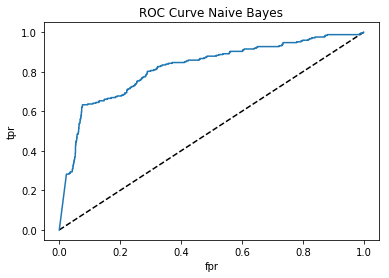

The area under the curve:  0.8207070334768336


In [22]:
############# Gaussian Naive-Bayes Classifier ###############
drunk_df_train_features, drunk_df_test_features, drunk_df_train_label, drunk_df_test_label = train_test_split(rescaled_drunk_features_df, drunk_label_df, train_size = 0.8, test_size = 0.2)

nb_classifier = GaussianNB()
nb_classifier = nb_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
accuracy_of_each_fold = cross_val_score(estimator=nb_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Accuracy of Naive-Bayes 10-fold cross validation: ", accuracy_of_each_fold.mean())

# Calculate the confusion matrix of this classifier
predictions = cross_val_predict(estimator=nb_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Confusion Matrix: ")
print(confusion_matrix(y_true=drunk_df_train_label.values, y_pred=predictions))
print("Classification Report: ")
print(classification_report(y_true=drunk_df_train_label.values, y_pred=predictions))
print("Horrible f1-score - there are too many false negatives!")

# Plot ROC curve!
predictions = nb_classifier.predict_proba(drunk_df_test_features)
fpr, tpr, threshold = roc_curve(drunk_df_test_label, predictions[:,1])
plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()
print("The area under the curve: ", roc_auc_score(drunk_df_test_label, predictions[:,1]))

In [24]:
############# Neural Network ###############
mlp_classifier = MLPClassifier(hidden_layer_sizes=(1,)) #single hidden layer
mlp_classifier = mlp_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)

criteria_nums = [(10,),(20,),(30,),(40,),(50,),(60,)]
activation_fns = ['logistic','tanh', 'relu']

parameters = {'hidden_layer_sizes': criteria_nums, 'activation': activation_fns}
gscv = GridSearchCV(estimator=mlp_classifier, param_grid=parameters, cv=5)
gscv.fit(drunk_df_train_features, drunk_df_train_label)
accuracyOfEachFold = cross_val_score(estimator=gscv, X=drunk_df_train_features, y=drunk_df_train_label, cv=5)
print("Official Accuracy: ", accuracyOfEachFold.mean())

Official Accuracy:  0.9302262174629886


In [ ]:
############## Random Forests ###############
rf_classifier = RandomForestClassifier()
rf_classifier = rfClassifier.fit(drunk_df_train_features, drunk_df_train_label)

depthNums = []
for i in range(35, 56):
    depthNums.append(i)
minSamples = [8, 10, 12]
maxFeatures = ['sqrt', 'log2']

parameters = {'max_depth': depthNums, 'min_samples_leaf': minSamples, 'max_features': maxFeatures}
gscv = GridSearchCV(estimator=rfClassifier, param_grid=parameters, cv=5)
gscv.fit(rescaledDfFeatures, dfLabel)
accuracyOfEachFold = cross_val_score(estimator=gscv, X=rescaledDfFeatures, y=dfLabel, cv=5)
print("Official Accuracy: ", accuracyOfEachFold.mean())